# Notebook to show how to analyse the results of the workplace dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import sklearn.metrics as sm

import vizCM as viz
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

import tools as tl

In [3]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams['figure.dpi'] = 300

In [4]:
''' Parameters '''
data = 'workplace'
in_folder = '../data/input/'
cU = False

In [5]:
''' Import data '''
filename = in_folder + data + '.npz'
df_meta = pd.read_csv(in_folder+data+'_meta.csv')
Data = np.load(filename, allow_pickle=True)
A = Data['A']
B = Data['B']
hye = Data['hyperedges']
hyL = [len(e) for eid, e in enumerate(hye)]

N, E = B.shape
Ds, countDs = np.unique(hyL, return_counts=True)
groups, countG = np.unique(df_meta['class'], return_counts=True)

print(f'Number of nodes N = {N}')
print(f'Number of hyperedges E = {E}')
print('Hyperedges degree, counts, and proportions:', Ds, countDs, np.round(countDs / sum(countDs), 3))
print('Metadata classes and counts:', groups, countG)

Number of nodes N = 92
Number of hyperedges E = 788
Hyperedges degree, counts, and proportions: [2 3 4] [742  44   2] [0.942 0.056 0.003]
Metadata classes and counts: ['DISQ' 'DMCT' 'DSE' 'SFLE' 'SRH'] [15 26 34  4 13]


### Communities
Results obtained by running ```main.py```

In [6]:
''' Import inferred parameters '''
theta_HyMT = np.load(f'../data/output/theta_{data}_cU{cU}_HyMT.npz')
theta_GrMT = np.load(f'../data/output/theta_{data}_cU{cU}_GrMT.npz')
theta_PaMT = np.load(f'../data/output/theta_{data}_cU{cU}_PaMT.npz')

In [7]:
''' Save membership matrices u'''
u = {'HyMT': tl.normalize_nonzero_membership(theta_HyMT['u']),
     'GrMT': tl.normalize_nonzero_membership(theta_GrMT['u']),
     'PaMT': tl.normalize_nonzero_membership(theta_PaMT['u'])}

In [8]:
''' Metadata partition '''
groups = df_meta['classID'].values
u['gt'] = np.zeros_like(u['HyMT'])
for i in range(N):
    u['gt'][i][groups[i]] = 1

In [9]:
''' Label permutation '''
for mod in ['HyMT', 'GrMT', 'PaMT']:
    P = tl.CalculatePermutation(u[mod], u['gt'])
    u[mod] = np.dot(u[mod], P)

In [10]:
''' Compute the F1-score between inferred communities and metadata partition '''
print('F1-score')
labels = {'HyMT': 'Hypergraph-MT', 'GrMT': 'Graph-MT', 'PaMT': 'Pairs-MT'}
for mod in ['HyMT', 'GrMT', 'PaMT']:
    print(labels[mod], 
          np.round(sm.f1_score(np.argmax(u['gt'], axis=1), np.argmax(u[mod], axis=1), average='weighted'), 3))

F1-score
Hypergraph-MT 0.839
Graph-MT 0.831
Pairs-MT 0.832


### Hyperedge prediction
Results obtained by running ```main_cv.py```

In [11]:
''' Import results of the 5-fold Cross-Validation routine '''
folds = pd.read_csv(f'../data/output/5-fold_cv/{data}_cU{cU}.csv')
assert len(folds) == 5

In [12]:
''' Average over the folds '''
np.round(np.mean(folds, axis=0)[9:], 3)

auc_test_HyMT         0.758
auc_test_GrMT         0.767
auc_test_HyMTpairs    0.741
auc_test_GrMTpairs    0.760
auc_test_PaMT         0.748
dtype: float64

In [13]:
''' Standard deviations over the folds '''
np.round(np.std(folds, axis=0)[9:], 3)

auc_test_HyMT         0.030
auc_test_GrMT         0.024
auc_test_HyMTpairs    0.034
auc_test_GrMTpairs    0.032
auc_test_PaMT         0.029
dtype: float64

### Plot communities

In [14]:
vcm = viz.vizCM(A, hye, {a: u[a] for a in u.keys()}, gt_labels=df_meta['classID'].values)
vcm.set_node_attributes(vcm.G)
vcm.set_node_attributes(vcm.G,algo='gt')
G = nx.Graph(vcm.G)

pos = nx.spring_layout(G, k=0.1, seed=0)

In [15]:
K = u['gt'].shape[1]
from_list = LinearSegmentedColormap.from_list
cmax = K+1
cm = from_list('tab20', plt.cm.tab20(range(0,cmax)), cmax)
cmap = cm

In [16]:
radius = 0.005

In [17]:
overlapping = True  # whether you want to plot overlapping or not communities

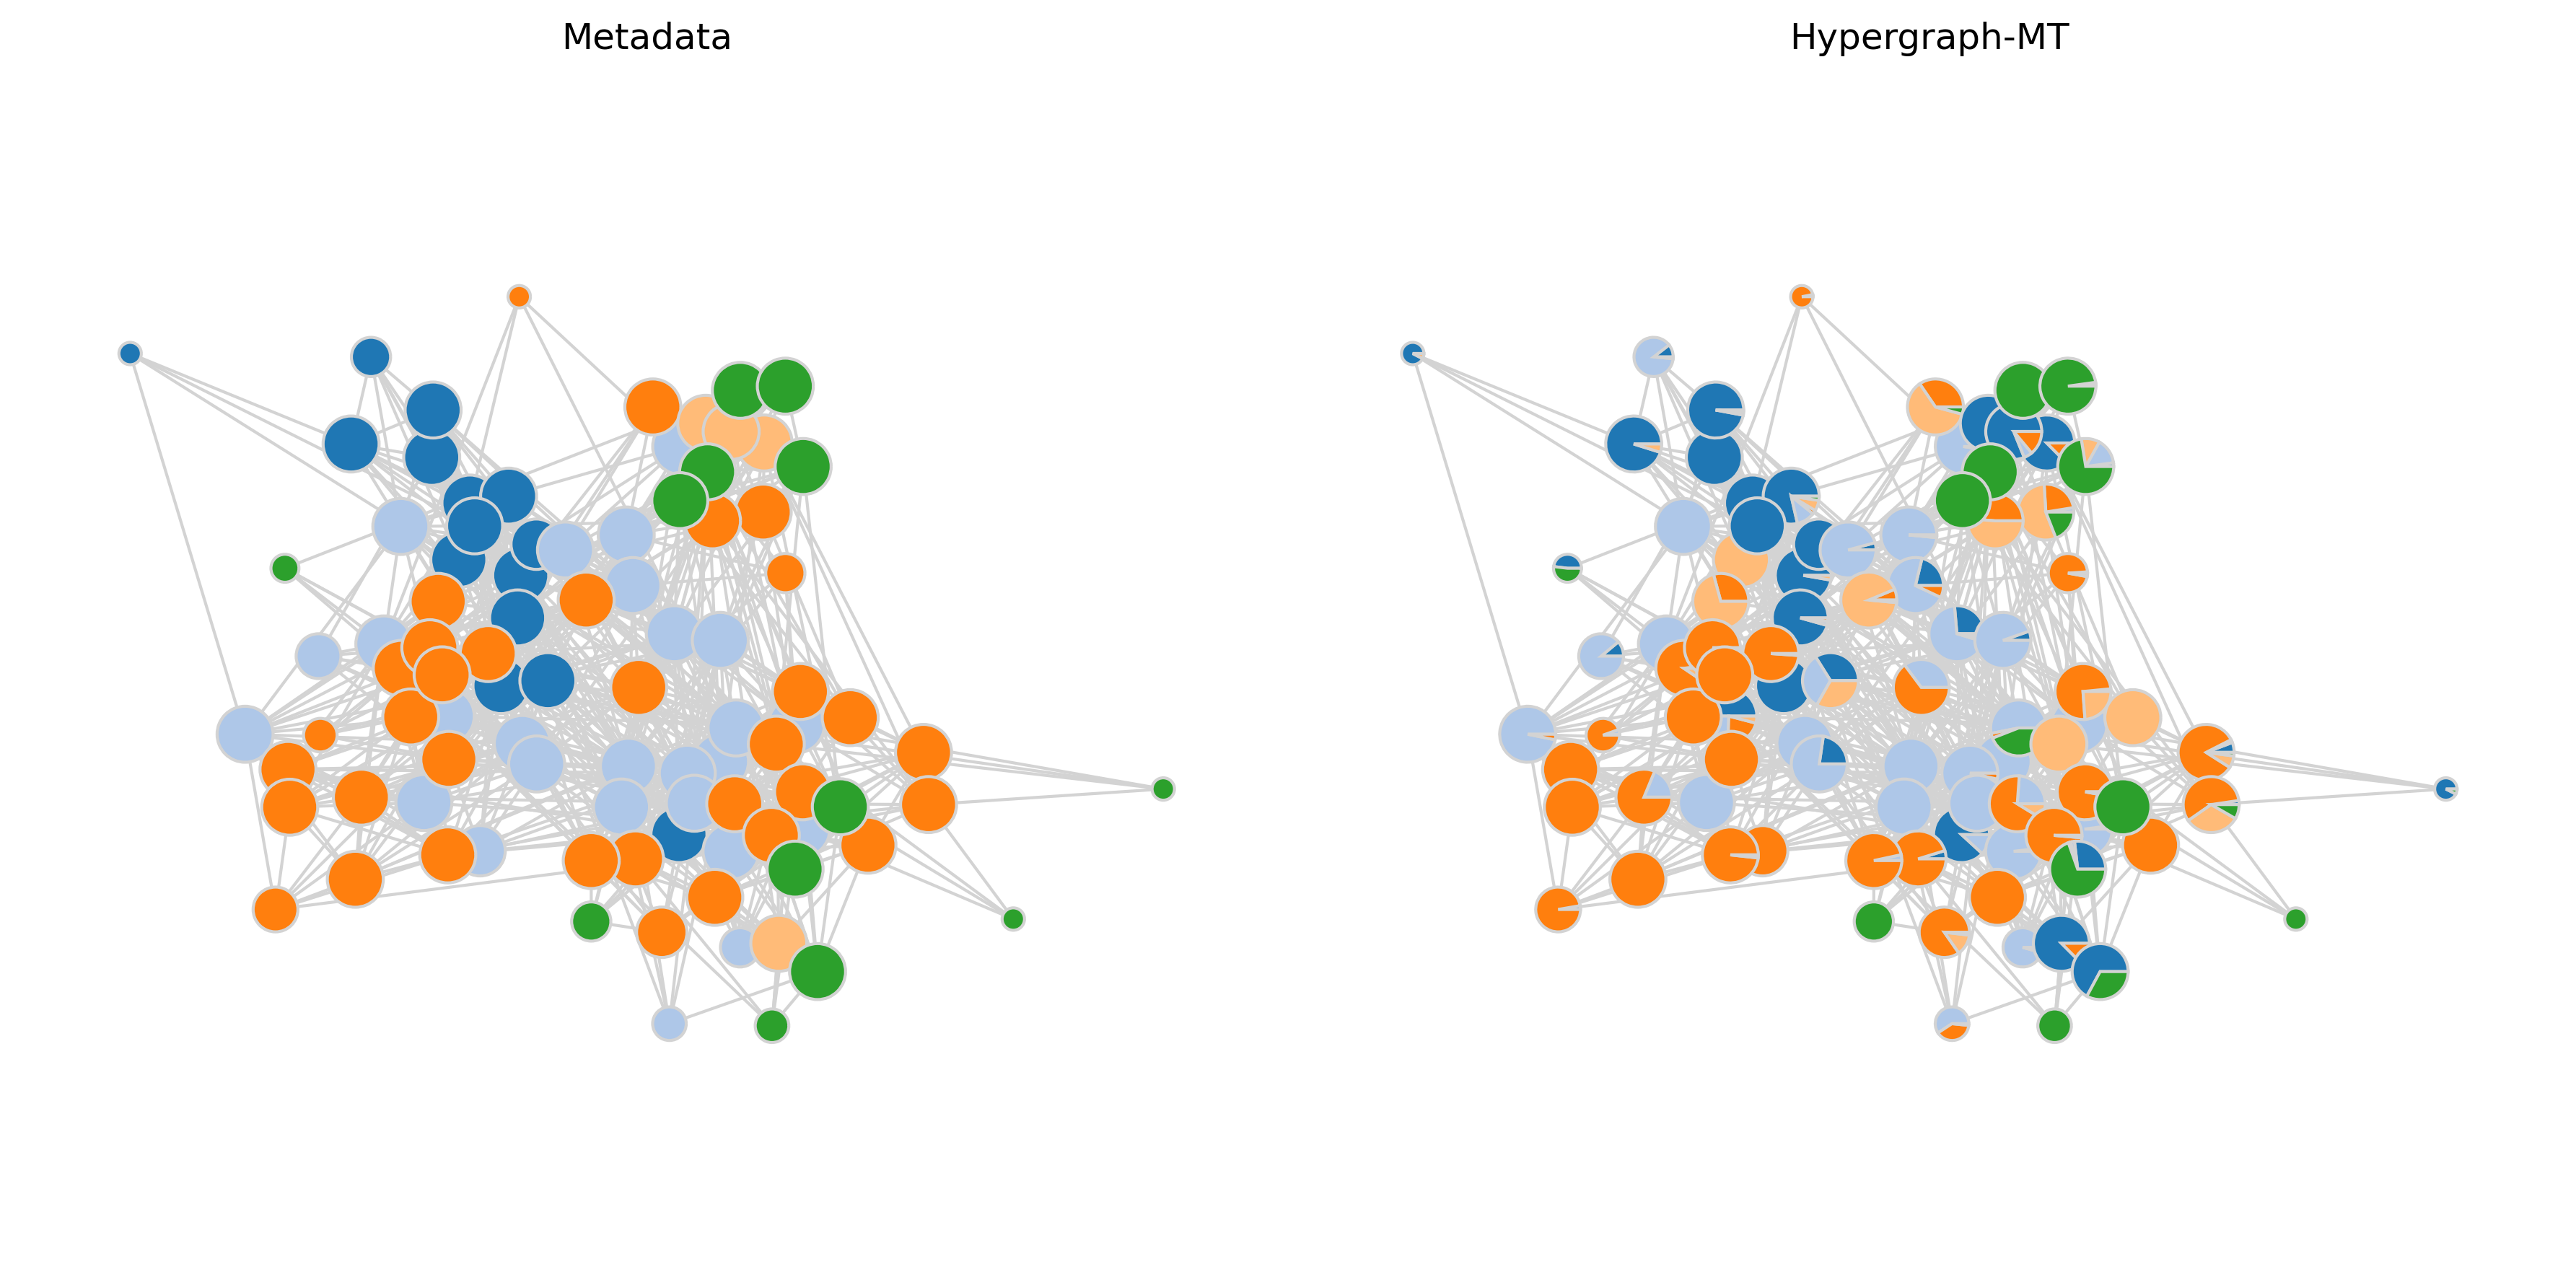

In [18]:
figsize = (12,6)
plt.figure(figsize = figsize)
ns = 50
mrk = 'o'
edgecolor_node = 'grey'
edgecolor_edge = 'lightgrey'
wedgeprops = {'edgecolor':edgecolor_edge}

degree = dict(G.degree())

if overlapping == True:
    plt.subplot(1,2,1)
    ax = plt.gca()
    nx.draw_networkx_edges(G, pos,arrows=False,edge_color=edgecolor_edge)
    for n,d in G.nodes(data=True):
        wedge_sizes,wedge_colors = viz.extract_bridge_properties(vcm.nodeName2Id[n],cm,vcm.U['gt'],threshold=0.01)
        if len(wedge_sizes)>0:
            pie,t = plt.pie(wedge_sizes, center=pos[n], colors = wedge_colors,radius=(min(10,degree[n]))*radius,wedgeprops=wedgeprops)
            ax.axis("equal")
    plt.tight_layout()
    plt.title('Metadata')

    plt.subplot(1,2,2)
    ax = plt.gca()
    nx.draw_networkx_edges(G, pos,arrows=False,edge_color=edgecolor_edge)
    for n,d in G.nodes(data=True):
        wedge_sizes,wedge_colors = viz.extract_bridge_properties(vcm.nodeName2Id[n],cm,vcm.U['HyMT'],threshold=0.01)
        if len(wedge_sizes)>0:
            pie,t = plt.pie(wedge_sizes, center=pos[n], colors = wedge_colors,radius=(min(10,degree[n]))*radius,wedgeprops=wedgeprops,normalize=True)
            ax.axis("equal")
    plt.tight_layout()
    plt.title('Hypergraph-MT')
    
else:
    plt.subplot(1,2,1)
    nx.draw_networkx_edges(G, pos,arrows=False,edge_color=edgecolor_edge)
    for n,d in G.nodes(data=True):
        nx.draw_networkx_nodes(G, pos, [n], node_size=ns, node_shape=mrk,node_color=[int(d['node_color_gt'])],edgecolors=edgecolor_node,cmap=cmap,vmin=0,vmax=cmax)
    plt.title('Metadata')

    plt.subplot(1,2,2)
    ax = plt.gca()
    nx.draw_networkx_edges(G, pos,arrows=False,edge_color=edgecolor_edge)
    for nid,n in enumerate(list(G.nodes())):
        nx.draw_networkx_nodes(G, pos, [n], node_size=ns, node_shape=mrk,node_color=[np.argmax(vcm.U['HyMT'][nid])],edgecolors=edgecolor_node,cmap=cmap,vmin=0,vmax=cmax)
    plt.title('Hypergraph-MT')